# Лабораторная работа №1: Реализация алгоритма SVM с различными ядрами

## Задание на лабораторную работу

### Задачи
1. Реализовать линейный SVM с помощью метода множителей Лагранжа и SMO алгоритма.
2. Реализовать ядерные функции:
   - Линейное:  $ K(x, y) = x \cdot y $
   - Полиномиальное:  $ K(x, y) = (x \cdot y + c)^d $
   - RBF (Гауссово):  $ K(x, y) = \exp(- \gamma  \|x - y \|^2) $
   - Сигмоидальное:  $ K(x, y) = \tanh( \alpha x \cdot y + c) $
3. Добавить soft-margin с параметром регуляризации $C$.
4. Исследовать влияние гиперпараметров:
   - $C$
   - $ \gamma $
   - степень $d$
5. Применить к задачам классификации и регрессии (SVR).
6. Сравнить с реализацией из scikit-learn.
7. Проанализировать опорные векторы и границу решений.
8. Оценить сложность для разных размеров данных.
### Структура отчета
1. **Введение** — цели и описание алгоритма.
2. **Теория** — математическое обоснование SVM и ядер.
3. **Реализация** — код (NumPy).
4. **Эксперименты** — исследование гиперпараметров.
5. **Сравнение** — результаты scikit-learn vs ваша реализация.
6. **Выводы** — анализ и рекомендации.

### Критерии оценивания (15 баллов)
- Реализация SVM (линейный + ядра) — 6 баллов
- Проведение экспериментов и подбор гиперпараметров — 5 баллов
- Сравнительный анализ с scikit-learn (таблицы, графики) — 3 балла
- Качество отчета: структура, визуализации, комментарии в коде — 1 балл

## Отчет

### 1. Введение

#### Цель

Целью лабораторной работы является изучение и написание алгоритма Support Vector Machine, а также решения задачи двойственного программирования с помощью множителей Лагранда

#### Описание

##### Линейный случай

 **В случае линейной классификации** основная идея SVM заключается в поиске гиперплоскости или линии, разделяющей классы наилучшим образом, а расположенные ближе всего к разделяющей гиперплоскости образцы называются _опорными векторами_. Лучшим разделением классов будет то, при котором максимизируется расстояние между опорными векторами и разделяющей гиперплоскостью. Это расстояние называется _зазором_. Здесь возможны 2 варианта:

- 1) **Классификация с жёстким зазором (hard margin)**, когда все обучающие образцы должны быть правильно классифицированы и находиться за пределами полосы разделения. Такой подход работает только в случае хорошей линейной разделимости данных и является довольно чувствительным к выбросам.
- 2) **Классификация с мягким зазором (soft margin)**, когда вводится допущение, что некоторые обучающие образцы могут нарушать условие правильной классификации или попадать в полосу разделения, но при этом вводится штраф за такие нарушения, пропорциональный **параметру C** (чем ниже данное значение, тем шире полоса и больше нарушений попадает в зазор). При таком подходе увеличивается обобщающая способность модели, что позволяет снизить риск переобучения.

Спрогнозированными классами будет линейная комбинация весов и тестовых признаков с использованием стратегии OVR (One-Versus-Rest) или OVA (One-Versus-All), а для минимизации используется функция потерь hinge.
$$\large
min\to C\sum_{i=1}^{n}max(0,1-y_{i}(w^TX+b))
$$
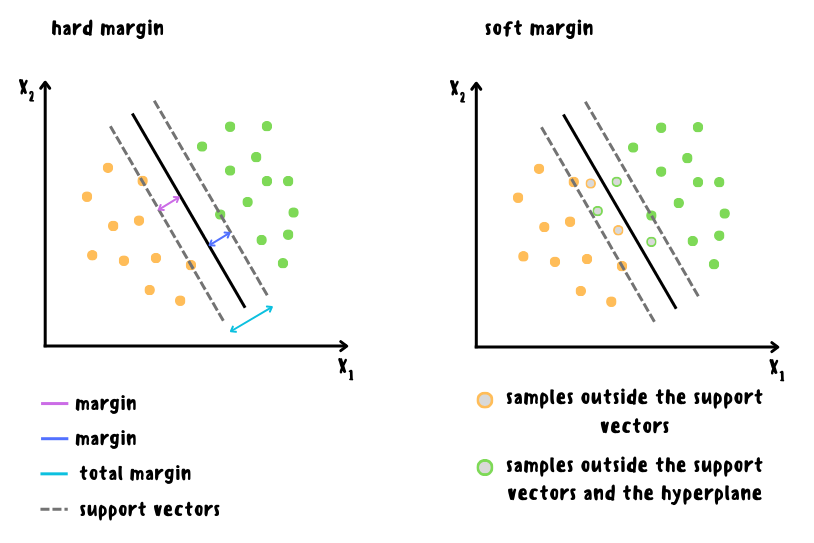

##### Нелинейный случай SVM

**В случае нелинейной классификации** данные преобразуются в пространство более высокой размерности, где они становятся линейно разделимыми. Одним из самых простых способов является добавление полиномиальных признаков, однако в таком случае сильно увеличивается вычислительная сложность.

Более интересным и эффективным способом является использование _ядерного трюка_ — это приём работы с данными в исходном пространстве, при котором скалярное произведение трансформированных векторов n-й степени заменяется на их произведение в степени n, что даёт аналогичный результат. Проще говоря, такой подход позволяет получить такие же результаты, как и в случае с добавлением большого количества полиномиальных признаков без их фактического добавления:
$$\large
\phi(a)^T\cdot \phi(b)=(a^T\cdot b)^n
$$
где $\large \phi$ - полиномиальная отображающая функция степени $\large n$.

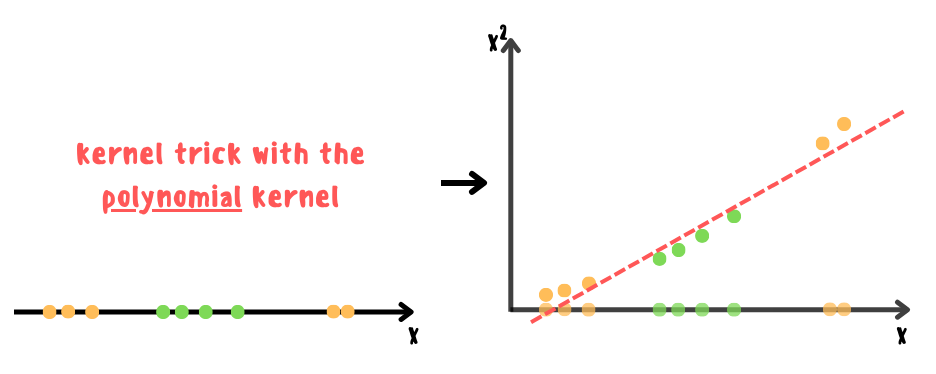


### 2. Математическое обоснование

#### Обоснование ядер


##### Линейное
$$\large
a^T\cdot b
$$
##### Полиномиальное
$$\large
(\gamma a^T\cdot b+r)^d
$$
##### Гауссовское RBF
$$\large
\exp(-\gamma||a-b||^2)
$$
##### Сигмоидальное
$$\large
\tanh(\gamma a^t\cdot b+r)
$$

В данном случае $\large \gamma$ — параметр, определяющий степень влияния между обучающими образцами: чем ниже данное значение, тем больше радиус влияния образцов на формирование решающей границы, что делает её более гладкой. Между тем коэффициент сдвига $\large r$ влияет на гибкость ядра, что позволяет создавать более сложные решающие границы.

#### Обоснование SVM

Будем решать задачу бинарной (когда класса всего два) классификации. Сначала алгоритм тренируется на объектах из обучающей выборки, для которых заранее известны метки классов. Далее уже обученный алгоритм предсказывает метку класса для каждого объекта из отложенной/тестовой выборки. Метки классов могут принимать значения $\large Y=\{-1,+1\}$. Объект - вектор с N признаками $\large x=(x_{1},\dots,x_{n})$ в пространстве $\large R^n$. При обучении алгоритм должен построить функцию $\large F(x)=y$, которая принимает в себя аргумент x - объект из пространства $\large R^n$ и выдает метку класса y.

Главная цель SVM как классификатора — найти уравнение разделяющей гиперплоскости $\large w_{1}x_{1}+w_{2}x_{2}+\dots+2_{n}x_{n}+w_{0}=0$ в пространстве $\large R^n$, которая бы разделила два класса неким оптимальным образом. Общий вид преобразования F объекта x в метку класса Y: $\large F(x)=sign(w^Tx-b)$. Обозначения: $\large (w_{1},w_{2},\dots,w_{n}),b=-w_{0}$. После обучения весов алгоритма w и b, все объекты, попадающие по одну сторону от построенной гиперплоскости, будут предсказываться как первый класс, а объекты, попадающие по другую сторону — второй класс.

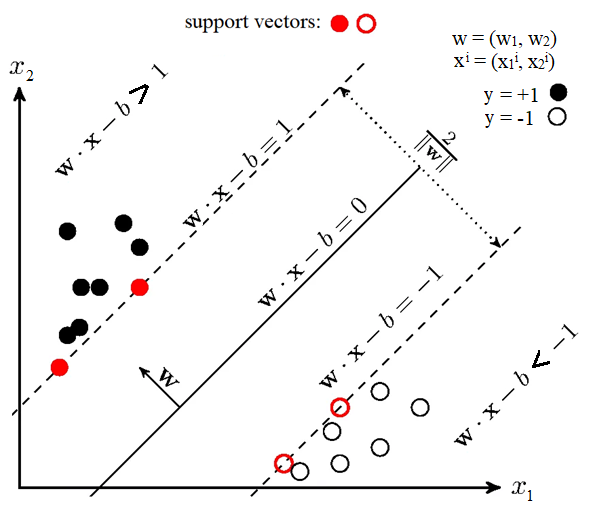

Чтобы разделяющая гиперплоскость как можно дальше отстояла от точек выборки, ширина полосы должна быть максимальной. Вектор $\large w$ - вектор нормали к разделяющей гиперплоскости. Здесь и далее будем обозначать скалярное произведение двух векторов как $\large \langle a,b\rangle$ или $\large a^Tb$. Давайте найдем проекцию вектора, концами которого являются опорные вектора разных классов, на вектор $\large w$. Эта проекция и будет показывать ширину разделяющей полосы.

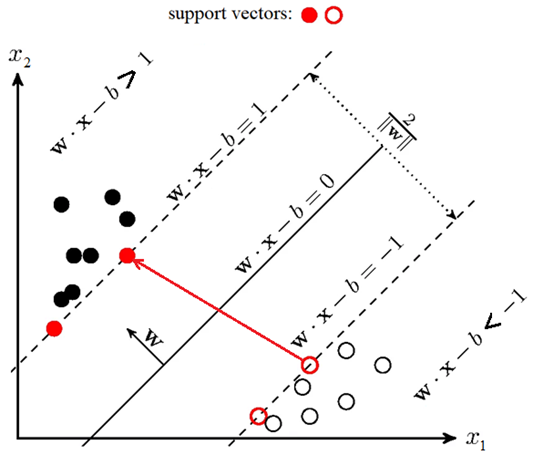

##### Нахождение расстояния от точки до гиперплоскости

1. **Возьмем любую точку на гиперплоскости.**  
    Пусть это точка `A` с координатами `x₀`. Так как она лежит на гиперплоскости, она удовлетворяет ее уравнению:  
    `wᵀx₀ + b = 0` => `b = - wᵀx₀`
2. **Посмотрим на вектор от точки A до точки P.**  
    Это вектор `(x - x₀)`.
3. **Расстояние — это длина проекции этого вектора на нормаль.**  
    Расстояние `ρ` от точки `P` до гиперплоскости — это длина перпендикуляра, опущенного из `P` на плоскость. А направление этого перпендикуляра как раз задается вектором нормали `w`.
    Поэтому нам нужно спроецировать вектор `(x - x₀)` на направление нормали `w` и взять длину этой проекции.
    - Проекция вектора `a` на вектор `b` вычисляется по формуле: `(a · b) / ||b||`
    - В нашем случае: `a = (x - x₀)`, `b = w`.
    **Проекция = `( (x - x₀) · w ) / ||w||`**
1. **Раскроем скалярное произведение.**  
    `(x - x₀) · w = w · (x - x₀) = wᵀx - wᵀx₀`
2. **Вспомним, чему равно `wᵀx₀`.**  
    Из пункта 1 мы знаем, что `wᵀx₀ = -b`. Подставим это:  
    `wᵀx - wᵀx₀ = wᵀx - (-b) = wᵀx + b`
3. **Итоговая формула для расстояния.**  
    Итак, проекция (а значит, и расстояние) равна:  
    `ρ = | wᵀx + b | / ||w||`

##### Нахождение ширины разделяющей полосы

$$\large
\begin{aligned} \langle(x_{+}-x_{-}),w/||w||)\rangle=(\langle x_{+},w\rangle-\langle x_{-},w\rangle)/||w||=((b+1)-(b-1))/||w||= \\ =2/||w| \end{aligned}
$$
$$\large
\begin{aligned} 2/||w||\to max \\ ||w||\to min \\ (w^Tw)/2\to min \end{aligned}
$$

##### Отступ

Отступом объекта x от границы классов называется величина $\large M=y(w^Tx-b)$. Алгоритм допускает ошибку на объекте тогда и только тогда, когда отступ M отрицателен (когда y и $\large (w^Tx-b)$ разных знаков). Если $\large M \in(0,1)$, то объект попадает внутрь разделяющей полосы. Если $\large M>1$, то объект х классифицируется правильно, и находится на некотором удалении от разделяющей полосы. Т.е алгоритм будет правильно классифицировать объекты, если выполняется условие: $\large y(w^Tx-b)\geq1$.

##### Hard-margin

Если объединить оба условия, то получается SVM с hard margin, когда никакому объекту нельзя попадать в полосу разделения. Решается аналитически через теорему Куна-Таккера. Получаемая задача эквивалентна двойственной задаче поиска седловой точки функции Лагранжа.
$$\large
\begin{cases} (w^Tw)/2\to min \\ y(w^Tx-b)\geq1 \end{cases}
$$

##### Soft-margin

Чтобы алгоритм смог работать и с линейно неразделимых данными, давайте немного преобразуем нашу систему. Позволим алгоритму допускать ошибки на обучающих объектах, но при этом постараемся, чтобы ошибок было поменьше. Введём набор дополнительных переменных $\large \xi_{i}>0$, характеризующих величину ошибки на каждом объекте $\large x_{i}$. Введем в минимизируемый функционал штраф за суммарную ошибку:
$$\large
\begin{cases} (w^Tw)/2+C \sum \xi_{i}\to min \\ y(w^Tx-b)\geq1-\xi_{i} \\ \xi_{i}\geq0 \end{cases}
$$
Будем считать количество ошибок алгоритма (когда M<0). Назовем это штрафом (_Penalty_). Тогда штраф для всех объектов будет равен сумме штрафов для каждого объекта $\large x_{i}$, где $\large [M_{i}<0]$ - пороговая функция.
$$\large
Penalty=\sum[M_{i}<0]
$$
$$\large
[M_{i}<0]=\begin{cases} 1,\,если\,M_{i}<0 \\ 0,\,если\,M_{i}\geq0 \end{cases}
$$
Далее сделаем штраф чувствительным к величине ошибки (чем сильнее M "уходит в минус" — тем больше штраф) и заодно введем штраф за приближение объекта к границе классов. Для этого возьмем функцию, которая ограничивает пороговую функцию ошибки:
$$\large
Penalty=\sum[M_{i}<0]\leq \sum(1-M_{i})_{+}=\sum max(0,1-M_{i})
$$
При добавлении к штрафу слагаемого $\large \alpha(w^tw)/2$ получаем классическую функцию потерь SVM с soft-margin для 1 объекта:
$$\large
Q=max(0,1-yw^Tx)+C(w^Tw)/2
$$
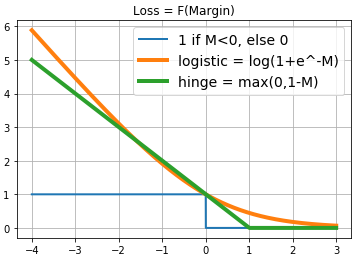

#### Переход к двойственной задаче

##### Строим Лагранжиан

Берем нашу задачу с ограничениями и превращаем ее в задачу без ограничений с помощью **множителей Лагранжа**.

Для каждой ограничивающей функции вводим множитель Лагранжа:
1. $\large \alpha_{i}\geq0$ для ограничений $\large y_{i}(w^Tx_{i}+b)-1+\xi_{i}\geq0$
2. $\large \mu_{i}\geq0$ для ограничений $\large \xi_{i}\geq0$

P.s: $\large \frac{1}{2}||w||^2=(w^Tw)/2$

**Лагранжиан:**
$$\large
L(w,b,\xi,\alpha,\mu)=\left( \frac{1}{2} \right)||w||^2+C\sum \xi_{i}-\sum \alpha_{i}[y_{i}(w^Tx_{i}+b)-1+\xi_{i}]-\sum \mu_{i}\xi_{i}
$$

##### Находим минимум по primal-переменным

**Primal-переменные** — это переменные **исходной** задачи оптимизации.

Используем условия Каруша-Куна-Таккера:
$$\large
minmaxL\leq maxminL
$$
Сначала минимизируем L по $\large w,b,\xi$:
1. По w: $\large \frac{\partial L}{\partial w}=w-\sum \alpha_{i}y_{i}x_{i}=0\implies w=\sum \alpha_{i}y_{i}x_{i}$
2. По b: $\large \frac{\partial L}{\partial b}=-\sum \alpha_{i}y_{i}=0\implies \sum \alpha_{i}y_{i}=0$
3. По $\large \xi_{i}$: $\large \frac{\partial L}{\partial \xi_{i}}=C-\alpha_{i}-\mu_{i}=0\implies \alpha_{i}+\mu_{i}=C$

##### Подставляем в Лагранжиан

$$\large
\begin{aligned} \frac{1}{2}||w||^2=\left( \frac{1}{2} \right)\left( \sum \alpha_{i}y_{i}x_{i} \right)^T\left( \sum \alpha_{j}y_{j}x_{j} \right)=\left( \frac{1}{2} \right)\sum \sum(\alpha_{i}\alpha_{j}y_{i}y_{j}(x_{i}^Tx_{j})) \\ C\sum \xi_{i}-\sum \alpha_{i}\xi_{i}-\sum \mu_{i}\xi_{i}=\sum(C-\alpha_{i}-\mu_{i})\xi_{i}=0 \\ -\sum \alpha_{i}[y_{i}(w^Tx_{i}+b)-1]=-\sum \alpha_{i}y_{i}w^Tx_{i}-b\sum \alpha_{i}y_{i}+\sum \alpha_{i} \\ 1). -\sum \alpha_{i}y_{i}w^Tx_{i}=-\sum \alpha_{i}y_{i}\left( \sum \alpha_{j}y_{j}x_{j} \right)^Tx_{i}=\sum \sum \alpha_{i}\alpha_{j}y_{i}y_{j}(x_{i}^Tx_{j}) \\ 2). b\sum \alpha_{i}y_{i}=0 \end{aligned}
$$

Итого:
$$\large
L=\sum \alpha_{i}-\left( \frac{1}{2} \right)\sum \sum \alpha_{i}\alpha_{j}y_{i}y_{j}(x_{i}^Tx_{j})
$$

##### Итоговая задача

$$\large
\begin{cases} W(\alpha)=\sum \alpha_{i}-\left( \frac{1}{2} \right)\sum \sum \alpha_{i}\alpha_{j}y_{i}y_{j}(x_{i}^Tx_{j}) \to max \\ 0\leq \alpha_{i}\leq C \\ \sum \alpha_{i}y_{i}=0 \end{cases}
$$

#### Simplified SMO

Вместо $\large x_{i}^Tx_{j}$ можно записать скалярное произведение $\large K=\langle x_{i},x_{j}\rangle$ и ввести понятие ядра.

Условия Каруша-Куна-Таккера могут использоваться для сходимости алгоритма к оптимальной точке:
$$\large
\begin{aligned} \alpha_{i}=0\implies y^{(i)}(w^Tx^{(i)}+b)\geq1 \\ \alpha_{i}=C\implies y^{(i)}(w^Tx^{(i)}+b)\leq1 \\ 0<\alpha_{i}<C\implies y^{(i)}(w^Tx^{(i)}+b)=1 \end{aligned}
$$
Любые $\large \alpha_{i}$, которые удовлетворяют этим условиям для всех i будут оптимальными решениями двойственной задачи. SMO итерируется до тех пор, пока все эти условия не будут выполнены.

**Идея SMO:** вместо того чтобы оптимизировать все $\large \alpha$ одновременно, будем оптимизировать **только два множителя Лагранжа за раз**, а остальные фиксировать. 

##### Выбор параметров $\large \alpha$

Изначальный алгоритм SMO максимизирует целевую функцию насколько это возможно, поэтому на больших датасетах сходимость может занять очень много времени, т.к всего возможных вариантов $\large \alpha_{i}$ и $\large \alpha_{j}$ - m(m − 1).

В упрощенном SMO итерируемся по всем m $\large \alpha_{i}$, а если $\large \alpha_{i}$ не удовлетворяет условиям ККТ, то мы рандомно выбираем $\large \alpha_{j}$ из оставшихся m-1 $\large \alpha$ и пытаемся оптимизировать $\large \alpha_{i}$ и $\large \alpha_{j}$ вместе. Если никакие из $\large \alpha$ не меняются несколько итераций, то алгоритм останавливается. 

**Simplified SMO не гарантирует сходимость к абсолютному минимуму, так как не перебирает все пары $\large \alpha_{i}$ $\large \alpha_{j}$**. 

##### Оптимизация $\large \alpha_{i}$ и $\large \alpha_{j}$

После выбора $\large \alpha_{i}$ и $\large \alpha_{j}$ необходимо сначала посчитать ограничения для этих параметров.

##### L и H

Сначала необходимо найти такие L и H, чтобы $\large L\leq \alpha_{j}\leq H$ для удовлетворения ограничения $\large 0\leq \alpha_{j}\leq C$. 
1. Если $\large y^{(i)}\neq y^{(j)},\,L=max(0,\alpha_{j}-\alpha_{i}),\,H=min(C,C+\alpha_{j}-\alpha_{i})$
2. Если $\large y^{(i)}=y^{(j)},\,L=max(0,\alpha_{i}+\alpha_{j}-C),\,H=min(C,\alpha_{i}+\alpha_{j})$

##### $\large \alpha_{j}$

Теперь нужно найти такое $\large \alpha_{j}$, чтобы максимизировать целевую функцию. Если это значение оказывается вне границ L и H, то мы просто ограничиваем это значение так, чтобы оно попадало в диапазон. Оптимальное значение $\large \alpha_{j}$ (здесь авторами статьи предлагается поразмыслить самостоятельно) находится по следущей формуле:
$$\large
\alpha_{j}:=\alpha_{j}-\frac{y^{(j)}(E_{i}-E_{j})}{\eta}
$$
где:
$$\large
\begin{aligned} E_{k}=f(x^{(k)})-y^{(k)} \\ \eta=2\langle x^{(i)},x^{(j)}\rangle - \langle x^{(i)},x^{(i)}\rangle -\langle x^{(j)},x^{(j)}\rangle \end{aligned}
$$
Теперь необходимо ограничить $\large \alpha_{j}$ в диапазоне $\large [L,H]$ как было сказано ранее:
$$\large
\alpha_{j}:=\begin{cases} H,\,if\,\alpha_{j}>H \\ \alpha_{j},\,if\,L\leq \alpha_{j}\leq H \\ L,\,if\,\alpha_{j}<L \end{cases}
$$

##### $\large \alpha_{i}$

Теперь можно найти $\large \alpha_{i}$:

$$\large
\alpha_{i}:=\alpha_{i}+y^{(i)}y^{(j)}(a_{j}^{(old)}-\alpha_{j})
$$
##### Параметр b

Если после оптимизации параметр $\large \alpha_{i}$ находится в границах $\large 0< \alpha_{i}< C$, то:
$$\large
b_{1}=b-E_{i}-y^{(i)}(\alpha_{i}-\alpha_{i}^{(old)})\langle x^{(i)},x^{(i)}\rangle -y^{(j)}(\alpha_{j}-\alpha_{j}^{(old)})\langle x^{(i)},x^{(j)}\rangle
$$
Если параметр $\large \alpha_{j}$ находится в границах $\large 0< \alpha_{j}< C$, то:
$$\large
b_{2}=b-E_{j}-y^{(i)}(\alpha_{i}-\alpha_{i}^{(old)})\langle x^{(i)},x^{(j)}\rangle -y^{(j)}(\alpha_{j}-\alpha_{j}^{(old)})\langle x^{(j)},x^{(j)}\rangle
$$
Если оба параметра находятся в границах, то вообще говоря $\large b_{1}=b_{2}$. Итоговое значение:
$$\large
b:=\begin{cases} b_{1},\,if\,0< \alpha_{j}< C\\ b_{1},\,if\,0< \alpha_{i}< C \\ \frac{b_{1}+b_{2}}{2},\,otherwise \end{cases}
$$

### 3. Реализация

#### Ядерные функции
Реализовать функции
- `linear_kernel`
- `poly_kernel`
- `rbf_kernel`
- `sigmoid_kernel`

In [1]:
from kernels import linear_kernel, rbf_kernel, sigmoid_kernel, poly_kernel

#### Реализация линейного SVM (SMO)

Не понял как я должен это сделать без C, в статье реализация SMO под soft-margin, метод не предполагает отсутствие C. Qwen тоже не понимает, как он должен это сделать, и предлагает сделать C = 1e10

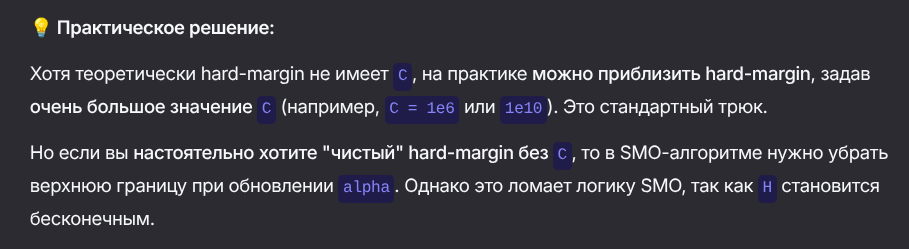

#### SVM с soft-margin
Добавьте поддержку параметра C и реализуйте SVR аналогично.

In [2]:
from SVM import SVM

#### SVR

In [3]:
from SVR import MySVR

### 4. Эксперименты

#### Wine

In [4]:
import pandas as pd
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.datasets import load_wine, fetch_california_housing, load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import defaultdict

In [5]:
data = load_wine()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
results_svm = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

##### rbf

In [7]:
# sklearn
param_grid = {
        'svc__kernel': ['rbf'],
        'svc__C': [0.1, 1, 10],
        'svc__gamma': [0.01, 0.1, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['wine']['rbf']['sklearn']['best_params'] = best_params
results_svm['wine']['rbf']['sklearn']['accuracy'] = accuracy

In [8]:
# my
param_grid = {
        'svm__kernel': [rbf_kernel],
        'svm__C': [0.1, 1, 10],
        'svm__gamma': [0.01, 0.1, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['wine']['rbf']['my']['best_params'] = best_params
results_svm['wine']['rbf']['my']['accuracy'] = accuracy

##### linear

In [9]:
# sklearn
param_grid = {
        'svc__kernel': ['linear'],
        'svc__C': [0.1, 1, 10]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['wine']['linear']['sklearn']['best_params'] = best_params
results_svm['wine']['linear']['sklearn']['accuracy'] = accuracy

In [10]:
# my
param_grid = {
        'svm__kernel': [linear_kernel],
        'svm__C': [0.1, 1, 10]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['wine']['linear']['my']['best_params'] = best_params
results_svm['wine']['linear']['my']['accuracy'] = accuracy

##### poly

In [11]:
# sklearn
param_grid = {
        'svc__kernel': ['poly'],
        'svc__C': [0.1, 1, 10],
        'svc__degree': [2, 3, 4],
        'svc__gamma': [0.01, 0.1, 1],
        'svc__coef0': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['wine']['poly']['sklearn']['best_params'] = best_params
results_svm['wine']['poly']['sklearn']['accuracy'] = accuracy

In [12]:
# my
param_grid = {
        'svm__kernel': [poly_kernel],
        'svm__C': [0.1, 1, 10],
        'svm__degree': [2, 3, 4],
        'svm__coef_r': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['wine']['poly']['my']['best_params'] = best_params
results_svm['wine']['poly']['my']['accuracy'] = accuracy

##### sigmoid

In [13]:
# sklearn
param_grid = {
        'svc__kernel': ['sigmoid'],
        'svc__C': [0.1, 1, 10],
        'svc__gamma': [0.01, 0.1, 1],
        'svc__coef0': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['wine']['sigmoid']['sklearn']['best_params'] = best_params
results_svm['wine']['sigmoid']['sklearn']['accuracy'] = accuracy

In [14]:
# my
param_grid = {
        'svm__kernel': [sigmoid_kernel],
        'svm__C': [0.1, 1, 10],
        'svm__alpha': [0.01, 0.1, 1],
        'svm__c': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['wine']['sigmoid']['my']['best_params'] = best_params
results_svm['wine']['sigmoid']['my']['accuracy'] = accuracy

#### Breast Canser

In [15]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### rbf

In [16]:
# sklearn
param_grid = {
        'svc__kernel': ['rbf'],
        'svc__C': [0.1, 1, 10],
        'svc__gamma': [0.01, 0.1, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['breast_canser']['rbf']['sklearn']['best_params'] = best_params
results_svm['breast_canser']['rbf']['sklearn']['accuracy'] = accuracy

In [17]:
# my
param_grid = {
        'svm__kernel': [rbf_kernel],
        'svm__C': [0.1, 1, 10],
        'svm__gamma': [0.01, 0.1, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['breast_canser']['rbf']['my']['best_params'] = best_params
results_svm['breast_canser']['rbf']['my']['accuracy'] = accuracy

##### linear

In [18]:
# sklearn
param_grid = {
        'svc__kernel': ['linear'],
        'svc__C': [0.1, 1, 10]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['breast_canser']['linear']['sklearn']['best_params'] = best_params
results_svm['breast_canser']['linear']['sklearn']['accuracy'] = accuracy

In [19]:
# my
param_grid = {
        'svm__kernel': [linear_kernel],
        'svm__C': [0.1, 1, 10]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['breast_canser']['linear']['my']['best_params'] = best_params
results_svm['breast_canser']['linear']['my']['accuracy'] = accuracy

##### poly

In [20]:
# sklearn
param_grid = {
        'svc__kernel': ['poly'],
        'svc__C': [0.1, 1, 10],
        'svc__degree': [2, 3, 4],
        'svc__gamma': [0.01, 0.1, 1],
        'svc__coef0': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['breast_canser']['poly']['sklearn']['best_params'] = best_params
results_svm['breast_canser']['poly']['sklearn']['accuracy'] = accuracy

In [21]:
# my
param_grid = {
        'svm__kernel': [poly_kernel],
        'svm__C': [0.1, 1, 10],
        'svm__degree': [2, 3, 4],
        'svm__coef_r': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['breast_canser']['poly']['my']['best_params'] = best_params
results_svm['breast_canser']['poly']['my']['accuracy'] = accuracy

##### sigmoid

In [22]:
# sklearn
param_grid = {
        'svc__kernel': ['sigmoid'],
        'svc__C': [0.1, 1, 10],
        'svc__gamma': [0.01, 0.1, 1],
        'svc__coef0': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['breast_canser']['sigmoid']['sklearn']['best_params'] = best_params
results_svm['breast_canser']['sigmoid']['sklearn']['accuracy'] = accuracy

In [23]:
# my
param_grid = {
        'svm__kernel': [sigmoid_kernel],
        'svm__C': [0.1, 1, 10],
        'svm__alpha': [0.01, 0.1, 1],
        'svm__c': [0, 1]
    }
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
results_svm['breast_canser']['sigmoid']['my']['best_params'] = best_params
results_svm['breast_canser']['sigmoid']['my']['accuracy'] = accuracy

### SVR

#### California Housing

In [24]:
data = fetch_california_housing()
X, y = data.data[:1000], data.target[:1000]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
results_svr = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

##### linear

In [26]:
param_grid_linear = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5]
}

pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='linear'))
])

grid = GridSearchCV(pipeline_linear, param_grid_linear, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
results_svr['california_housing']['linear']['sklearn']['best_params'] = best_params
results_svr['california_housing']['linear']['sklearn']['mean_squared_error'] = mse

In [27]:
param_grid_linear = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5]
}

pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', MySVR(kernel=linear_kernel))
])

grid = GridSearchCV(pipeline_linear, param_grid_linear, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
results_svr['california_housing']['linear']['my']['best_params'] = best_params
results_svr['california_housing']['linear']['my']['mean_squared_error'] = mse

##### poly

In [28]:
param_grid_poly = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.1, 0.2, 0.5],
    'svr__degree': [2, 3, 4],
    'svr__coef0': [0, 0.5, 1, 2]
}

pipeline_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='poly'))
])

grid = GridSearchCV(pipeline_poly, param_grid_poly, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
results_svr['california_housing']['poly']['sklearn']['best_params'] = best_params
results_svr['california_housing']['poly']['sklearn']['mean_squared_error'] = mse

In [29]:
param_grid_poly = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.1, 0.2, 0.5],
    'svr__degree': [2, 3, 4],
    'svr__coef_r': [0, 1]
}

pipeline_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', MySVR(kernel=poly_kernel))
])

grid = GridSearchCV(pipeline_poly, param_grid_poly, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
results_svr['california_housing']['poly']['my']['best_params'] = best_params
results_svr['california_housing']['poly']['my']['mean_squared_error'] = mse

##### sigmoid

In [30]:
param_grid_sigmoid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.1, 0.2, 0.5],
    'svr__gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'svr__coef0': [0, 0.5, 1, 2]
}

pipeline_sigmoid = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='sigmoid'))
])

grid = GridSearchCV(pipeline_sigmoid, param_grid_sigmoid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
results_svr['california_housing']['sigmoid']['sklearn']['best_params'] = best_params
results_svr['california_housing']['sigmoid']['sklearn']['mean_squared_error'] = mse

In [31]:
param_grid_sigmoid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.1, 0.2, 0.5],
    'svr__alpha': [0.01, 0.1, 1],
    'svr__c': [0, 0.5, 1, 2]
}

pipeline_sigmoid = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', MySVR(kernel=sigmoid_kernel))
])

grid = GridSearchCV(pipeline_sigmoid, param_grid_sigmoid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
results_svr['california_housing']['sigmoid']['my']['best_params'] = best_params
results_svr['california_housing']['sigmoid']['my']['mean_squared_error'] = mse

##### rbf

In [32]:
param_grid_rbf = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5]
}

pipeline_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))
])

grid = GridSearchCV(pipeline_rbf, param_grid_rbf, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
results_svr['california_housing']['rbf']['sklearn']['best_params'] = best_params
results_svr['california_housing']['rbf']['sklearn']['mean_squared_error'] = mse

In [33]:
param_grid_rbf = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': [0.001, 0.01, 0.1, 1],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5]
}

pipeline_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', MySVR(kernel=rbf_kernel))
])

grid = GridSearchCV(pipeline_rbf, param_grid_rbf, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
results_svr['california_housing']['rbf']['my']['best_params'] = best_params
results_svr['california_housing']['rbf']['my']['mean_squared_error'] = mse

### 5. Сравнение

In [34]:
results_svm_df = pd.DataFrame([
    {
        'dataset': dataset,
        'kernel': kernel, 
        'implementation': impl,
        'accuracy': results_svm[dataset][kernel][impl]['accuracy'],
        'best_params': results_svm[dataset][kernel][impl]['best_params']
    }
    for dataset in results_svm
    for kernel in results_svm[dataset]
    for impl in results_svm[dataset][kernel]
])

In [44]:
results_svr_df = pd.DataFrame([
    {
        'dataset': dataset,
        'kernel': kernel, 
        'implementation': impl,
        'mean_squared_error': round(results_svr[dataset][kernel][impl]['mean_squared_error'], 7),
        'best_params': results_svr[dataset][kernel][impl]['best_params']
    }
    for dataset in results_svr
    for kernel in results_svr[dataset]
    for impl in results_svr[dataset][kernel]
])

In [37]:
results_svm_df

,dataset,kernel,implementation,accuracy,best_params
0,wine,rbf,sklearn,1.000000,"{'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel..."
1,wine,rbf,my,0.981481,"{'svm__C': 1, 'svm__gamma': 0.01, 'svm__kernel..."
2,wine,linear,sklearn,0.981481,"{'svc__C': 1, 'svc__kernel': 'linear'}"
3,wine,linear,my,0.981481,"{'svm__C': 1, 'svm__kernel': <function linear_..."
4,wine,poly,sklearn,0.981481,"{'svc__C': 10, 'svc__coef0': 1, 'svc__degree':..."
5,wine,poly,my,0.981481,"{'svm__C': 0.1, 'svm__coef_r': 1, 'svm__degree..."
6,wine,sigmoid,sklearn,0.981481,"{'svc__C': 1, 'svc__coef0': 0, 'svc__gamma': 0..."
7,wine,sigmoid,my,0.981481,"{'svm__C': 1, 'svm__alpha': 0.01, 'svm__c': 0,..."
8,breast_canser,rbf,sklearn,0.988304,"{'svc__C': 10, 'svc__gamma': 0.01, 'svc__kerne..."
9,breast_canser,rbf,my,0.988304,"{'svm__C': 10, 'svm__gamma': 0.01, 'svm__kerne..."


In [46]:
pd.options.display.float_format = '{:.5f}'.format
results_svr_df

,dataset,kernel,implementation,mean_squared_error,best_params
0,california_housing,linear,sklearn,0.22125,"{'svr__C': 0.1, 'svr__epsilon': 0.5}"
1,california_housing,linear,my,1.59888,"{'svr__C': 1, 'svr__epsilon': 0.01}"
2,california_housing,poly,sklearn,0.14341,"{'svr__C': 0.1, 'svr__coef0': 1, 'svr__degree'..."
3,california_housing,poly,my,21176756708856160256.00000,"{'svr__C': 10, 'svr__coef_r': 0, 'svr__degree'..."
4,california_housing,sigmoid,sklearn,0.22595,"{'svr__C': 1, 'svr__coef0': 0, 'svr__epsilon':..."
5,california_housing,sigmoid,my,68020075.50016,"{'svr__C': 100, 'svr__alpha': 1, 'svr__c': 2, ..."
6,california_housing,rbf,sklearn,0.17521,"{'svr__C': 10, 'svr__epsilon': 0.2, 'svr__gamm..."
7,california_housing,rbf,my,13.14776,"{'svr__C': 100, 'svr__epsilon': 0.5, 'svr__gam..."


### 6. Выводы
   - Обсудите влияние гиперпараметров.
   - Сравните производительность и время обучения.
   - Дайте рекомендации по выбору ядер.

#### Влияние гиперпараметров

Я могу констатировать расхождение в гиперпараметрах у самописных моделей и реализаций из sklearn по итогам GridSearch. Скорее всего, это связано с разной реализацией решения двойственной задачи, так как метод, предложенный в самописных моделях, не гарантирует нахождение глобального минимума функции

#### Производительность и время обучения

Самописные модели обучаются значительно дольше, так как (вероятно) не обладают должной оптимизацией

#### Выбор ядер

Ядро должно выбираться исходя из природы данных. Нелинейные зависимости в данных невозможно выявить линейным ядром

#### 